# TOI-1130 photoTRADES

In [1]:
import numpy as np
import os
import sys
# import glob
# import time as timer
from astropy.time import Time
from astropy.io import fits
from astropy.table import Table
from pytransit import RoadRunnerModel
import matplotlib.pyplot as plt

Import `pytrades`

In [2]:
from pytrades import constants as cst
from pytrades import ancillary as anc
from pytrades import pytrades

Set `rcParams` with my default values

In [3]:
anc.set_rcParams()

Define input and output folders

In [4]:
here_folder = os.path.abspath(".")

photometry_folder = os.path.join(here_folder, "photometry")
# radial_velocities_folder = os.path.join(here_folder, "radial_velocities")
# transit_times_folder = os.path.join(here_folder, "transit_times")

out_folder = os.path.join(here_folder, "output")
os.makedirs(out_folder, exist_ok=True)

map_out_folder = os.path.join(out_folder, "01_map")
os.makedirs(map_out_folder, exist_ok=True)

## Photometry

### TESS

In [5]:
# tess_s13_file = os.path.join(
#     photometry_folder, 
#     "hlsp_qlp_tess_ffi_s0013-0000000254113311_tess_v01_llc.txt"
# )
# time_s13, flux_sap_s13, flux_sap_err_s13 = np.genfromtxt(tess_s13_file, delimiter=",", unpack=True)

tess_s13_file = os.path.join(
    photometry_folder, 
    "hlsp_qlp_tess_ffi_s0013-0000000254113311_tess_v01_llc.fits"
)
with fits.open(tess_s13_file) as hdul:
    print(hdul.info())
    s13_header = hdul[1].header
    tess_s13 = Table(hdul[1].data)

# print(s13_header)
texp = s13_header["TIMEDEL"]
print("exposure time = {:.6f}d == {:.0f}".format(texp, texp*cst.day2sec))
n_over = int(texp*cst.day2sec / 120.0)+1

Filename: /home/borsato/Dropbox/Coding/python/trades_check/photoTRADES_TOI-1130/photometry/hlsp_qlp_tess_ffi_s0013-0000000254113311_tess_v01_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  LIGHTCURVE    1 BinTableHDU     65   1320R x 13C   [D, J, E, E, E, J, J, E, E, E, E, E, E]   
None
exposure time = 0.020833d == 1800


In [6]:
time_s13, flux_sap_s13, flux_sap_err_s13 = tess_s13["TIME"], tess_s13["KSPSAP_FLUX"], tess_s13["KSPSAP_FLUX_ERR"]
quality = tess_s13["QUALITY"]
ok = np.logical_and(
    np.isnan(flux_sap_s13) == False,
    quality == 0
)
time_s13, flux_sap_s13, flux_sap_err_s13 = time_s13[ok], flux_sap_s13[ok], flux_sap_err_s13[ok]

In [7]:
# fig = plt.figure()

# plt.title("TESS-S13")
# plt.errorbar(
#     time_s13, flux_sap_s13,
#     yerr=flux_sap_err_s13,
#     color='black',
#     fmt='o',
#     ms=1.5,
#     ls='',
#     ecolor='gray',
#     elinewidth=0.4,
#     capsize=0
# )

# plt.show()
# plt.close(fig)

3 CHEOPS LCs AS TEST

In [8]:
# a transit of planet b
file_cheops = os.path.join(
    photometry_folder,
    "CHEOPS-PIPE_TOI-1130b_v04_CH_PR100031_TG042201_V0200_detrended.dat"
)
time_cheops_b, flux_cheops_b, flux_cheops_err_b = np.genfromtxt(file_cheops, usecols=(0,1,2), unpack=True)

In [9]:
# a transit of planet c
file_cheops = os.path.join(
    photometry_folder,
    "CHEOPS-PIPE_TOI-1130c_v03_CH_PR100015_TG018201_V0200_detrended.dat"
)
time_cheops_c, flux_cheops_c, flux_cheops_err_c = np.genfromtxt(file_cheops, usecols=(0,1,2), unpack=True)

In [10]:
# the transit of planet b and c
file_cheops = os.path.join(
    photometry_folder,
    "CHEOPS-PIPE_TOI-1130c_v06_CH_PR120053_TG004701_V0200_normalized.dat"
)
time_cheops_bc, flux_cheops_bc, flux_cheops_err_bc = np.genfromtxt(file_cheops, usecols=(0,1,2), unpack=True)

## Radial Velocities

### NONE

In [11]:
t_rv_obs = []

## Transit times

### NONE

## Set `pytrades` configuration

In [12]:
time_all = np.concatenate((time_s13, time_cheops_b, time_cheops_c, time_cheops_bc))
t_epoch = 1657.0
t_start = np.min(time_all) - 10.0
# t_start = t_epoch
# t_end = Time("2023-08-30T00:00:00", format="isot", scale="tdb").jd - cst.btjd
t_end = np.max(time_all) + 1.0
t_int = t_end - t_start

print("t_epoch = {}".format(t_epoch))
print("t_start = {}".format(t_start))
print("t_end   = {}".format(t_end))
print("total integration time: {} days".format(t_int))

body_names = ["star", "b", "c"]
n_body = len(
    body_names
)  # number of bodies (NOT PLANETS) in the system, that is star + planets

t_epoch = 1657.0
t_start = 1647.7246043610537
t_end   = 2752.82400874
total integration time: 1105.0994043789462 days


Let's define the system parameters

In [13]:
M_msun = np.array(
    [0.745059, 19.833346 * cst.Mears, 335.603435 * cst.Mears]
)  # Masses in Solar unit
R_rsun = np.array(
    [0.697470, 3.657000 * cst.Rears, 12.983016 * cst.Rears]
)  # Radii in Solar unit
P_day = np.array([0.0, 4.074554, 8.350190])  # Periods in days
ecc_val = np.array([0.0, 0.0521624, 0.039773])  # eccentricities
argp_deg = np.array([0.0, 141.11112, 182.502357])  # argument of pericenters in degrees
mA_deg = np.array([0.0, 159.696701, 233.068994])  # mean anonalies in degrees
inc_deg = np.array([0.0, 87.494901, 87.613475])  # inclinations in degrees
lN_deg = np.array([0.0, 180.0, 179.993043])  # longitude of ascending nodes in degrees

### Within `photoTRADES` object/version ... skip it

In [14]:
# sim = pytrades.PhotoTRADES(
#     n_body,
#     t_epoch,
#     t_start,
#     t_int,
#     duration_check=1,
#     encounter_check=True,
#     do_hill_check=False,
#     amd_hill_check=False,
#     rv_res_gls=False,
# )

In [15]:
# sim.add_default_physical_parameters(
#     M_msun, R_rsun, P_day, ecc_val, argp_deg, mA_deg, inc_deg, lN_deg
# )

Try the functions to simulate transit times, radial velocities, and photometry

Run the simulation as splitted in transit times + radial velocities ...

In [16]:
# (
#     time_steps,
#     orbits,
#     transits,
#     durations,
#     lambda_rm,
#     kep_elem,
#     body_flag,
#     rv_sim,
#     stable,
# ) = sim.orbital_parameters_to_transits(
#     M_msun, R_rsun, P_day, ecc_val, argp_deg, mA_deg, inc_deg, lN_deg
# )

### `pytrades` simple version

Initialise `trades` only once

In [18]:
pytrades.args_init(
    n_body, # mandatory
    1, # duration_check # mandatory
    t_epoch=None, # not needed here
    t_start=None, # not needed here
    t_int=None, # not needed here
    encounter_check=True, # better alway True, we do not want close encounters!
    do_hill_check=False, # at will, as input option
    amd_hill_check=False, # at will, as input option
    rv_res_gls=False, # at will, as input option
)

Integrates and compute transit times, durations, etc. To be called within the log-likelihood

In [19]:
(
    time_steps,
    orbits,
    transits,
    durations,
    lambda_rm,
    kep_elem,
    body_flag,
    rv_sim, # {"time": array, "rv": array} the index will match the input t_rv_obs array
    stable,
) = pytrades.orbital_parameters_to_transits(
    t_epoch, t_start, t_int, M_msun, R_rsun, P_day, ecc_val, argp_deg, mA_deg, inc_deg, lN_deg,
    t_rv_obs # this can be an empty list [] and it will ignore it, otherwise provide a list time at which compute RV
)

No issues not providing observed RV or Transit times

In [20]:
print(rv_sim)

{'time': array([], dtype=float64), 'rv': array([], dtype=float64)}


Function to compute the photometry at each transit for all bodies

In [21]:
def compute_single_flux_pytransit(tm, time_in, transits, durations, rp_rs, per, aRs, inc, ecc, w, ld_quad, n_over=1, texpd=None):

    t = np.asarray(time_in) # for convenience
    
    f1 = np.ones((len(t))) # create a model at 1.0 for all time points
    half_dur_d = durations * cst.min2day # compute half duration in days for all the transits of all the planets
    
    # select transit times of all planets in the time range
    tra_in_t = np.logical_and(transits >= t.min(), transits <= t.max())
    n_tra = np.sum(tra_in_t)
    
    # select partial transits of all planets in the time range
    tra_dur_in_t = np.logical_and(
        transits - half_dur_d >= t.min(),
        transits + half_dur_d <= t.max(),
    )
    n_dur = np.sum(tra_dur_in_t)
    # number of events based on the max between n_tra and n_dur
    if n_tra >= n_dur:
        n = n_tra
        sel_tra = tra_in_t
    else:
        n = n_dur
        sel_tra = tra_dur_in_t

    # compute transit model only if full or partial transits have been found
    if n > 0:
        # select transits and parameters
        tra_sel = np.atleast_1d(transits[sel_tra])
        rp_rs_sel = np.atleast_1d(rp_rs[sel_tra])
        per_sel = np.atleast_1d(per[sel_tra])
        aRs_sel = np.atleast_1d(aRs[sel_tra])
        inc_sel = np.atleast_1d(inc[sel_tra])
        ecc_sel = np.atleast_1d(ecc[sel_tra])
        w_sel = np.atleast_1d(w[sel_tra])

        flux_ = []
        for itra, tra in enumerate(tra_sel): # loop in the selected transits (independent of the body)
            ff = f1.copy()
            sel_t = np.logical_and(
                t >= tra - 0.5 * per[itra],
                t <= tra + 0.5 * per[itra],
            ) # select portion of the light curve centered on the transit time that cover a full period
            tm.set_data(t[sel_t], nsamples=n_over, exptimes=texpd) # set the pytransit time data with oversampling if needed
            ff[sel_t] = tm.evaluate(
                k=rp_rs_sel[itra],
                ldc=ld_quad,
                t0=tra,
                p=per_sel[itra],
                a=aRs_sel[itra],
                i=inc_sel[itra],
                e=ecc_sel[itra],
                w=w_sel[itra],
            ) # compute the model and associate it only for the selected portion close to the transit
            flux_.append(ff) # append it
        f2d = np.atleast_2d(flux_)
        flux = np.sum(f2d - 1.0, axis=0) + 1.0 # in one step it removes 1, sum flux for each time point, the re-add 1
    else: # set to 1.0 the model flux if there are not transits (full or partials) in this photometry
        flux = f1

    return flux

define the LD for TESS

In [22]:
ld_vals = {
    "tess": np.array([0.385, 0.322]),
    "cheops": np.array([0.30, 0.41])
}
ld_quads = {k: v.copy() for k, v in ld_vals.items()}
print(ld_quads)

{'tess': array([0.385, 0.322]), 'cheops': array([0.3 , 0.41])}


Instantiate the `pytransit` or `batman` model.
Do it at the beginning, avoid to create it for each log-likelihood.

In [23]:
tm = RoadRunnerModel("quadratic")

Prepare the parameters for pytransit (do it just once per log-likelihood computation)

In [24]:
rp_rs, per, aRs, inc, ecc, w = pytrades.set_transit_parameters(
    R_rsun, transits, body_flag, kep_elem
)
# they match transits variable row-by-row

In [25]:
flux_model = compute_single_flux_pytransit(
    tm, 
    time_s13, 
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["tess"],
    n_over=n_over,
    texpd=texp
)

# just to have a full model (oversampled) and covering the gaps
texpover = 120*cst.sec2day
time_over = np.arange(time_s13.min()-1.0, time_s13.max()+1.0, texpover)
flux_model_over = compute_single_flux_pytransit(
    tm,
    time_over,
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["tess"],
    n_over=1,
    texpd=None
)

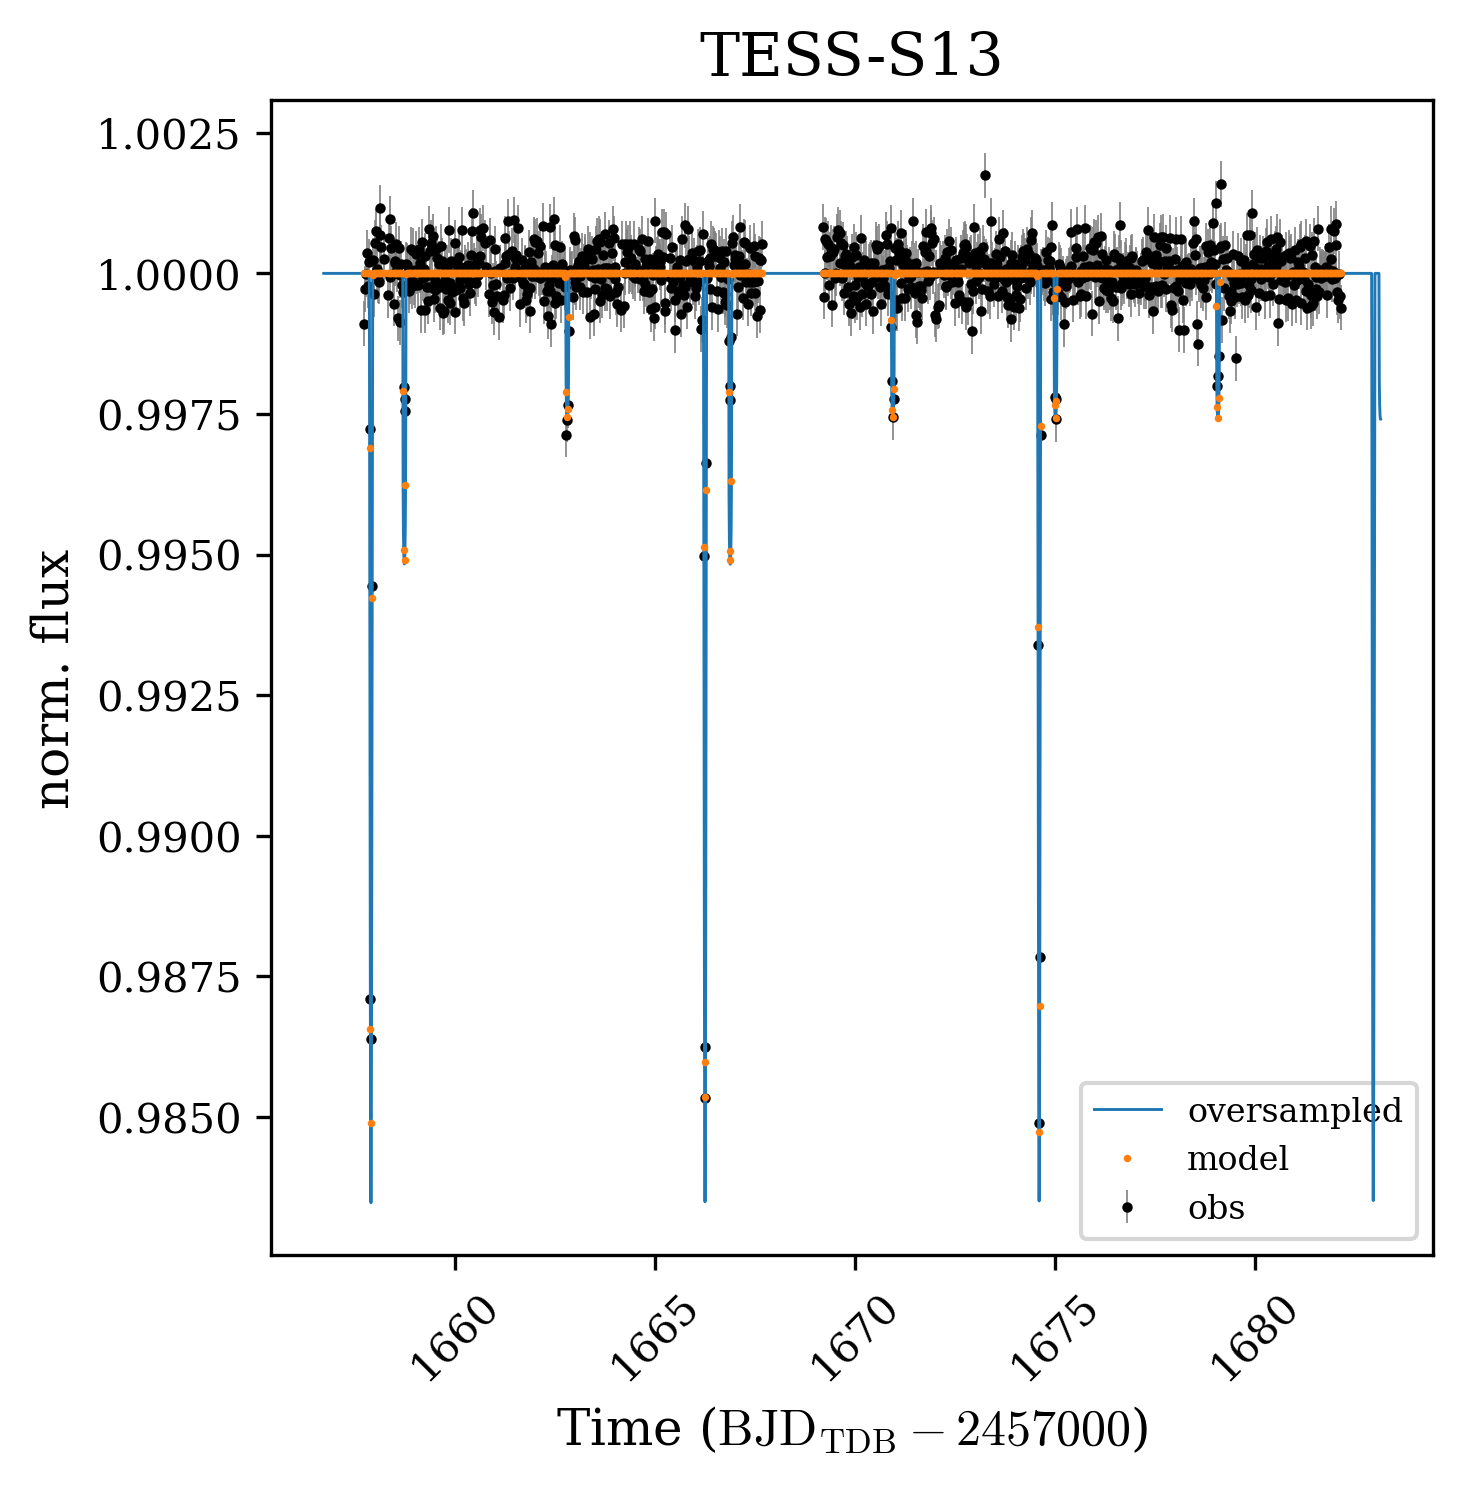

In [26]:
fig = plt.figure()

plt.title("TESS-S13")
plt.errorbar(
    time_s13, flux_sap_s13,
    yerr=flux_sap_err_s13,
    color='black',
    fmt='o',
    ms=1.5,
    ls='',
    ecolor='gray',
    elinewidth=0.4,
    capsize=0,
    label="obs",
    zorder=6
)

plt.plot(
    time_over,
    flux_model_over,
    color='C0',
    marker='None',
    ls='-',
    lw=0.7,
    label='oversampled',
    zorder=7
)

plt.plot(
    time_s13,
    flux_model,
    color='C1',
    marker='o',
    ms=1.8,
    mec='None',
    ls='',
    label='model',
    zorder=8
)

plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize=8)

# # a zoom
# x1, x2 = 1666, 1667.25
# plt.xlim(x1,x2)

plt.xlabel("Time ($\mathrm{BJD_{TDB}} - 2457000$)")
plt.ylabel("norm. flux")

plt.show()
plt.close(fig)

In [27]:
flux_model = compute_single_flux_pytransit(
    tm, 
    time_cheops_b, 
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["cheops"],
    n_over=1,
    texpd=None
)

# just to have a full model (oversampled) and covering the gaps
texpover = 60*cst.sec2day
time_over = np.arange(time_cheops_b.min()-0.25, time_cheops_b.max()+0.25, texpover)
flux_model_over = compute_single_flux_pytransit(
    tm,
    time_over,
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["cheops"],
    n_over=1,
    texpd=None
)

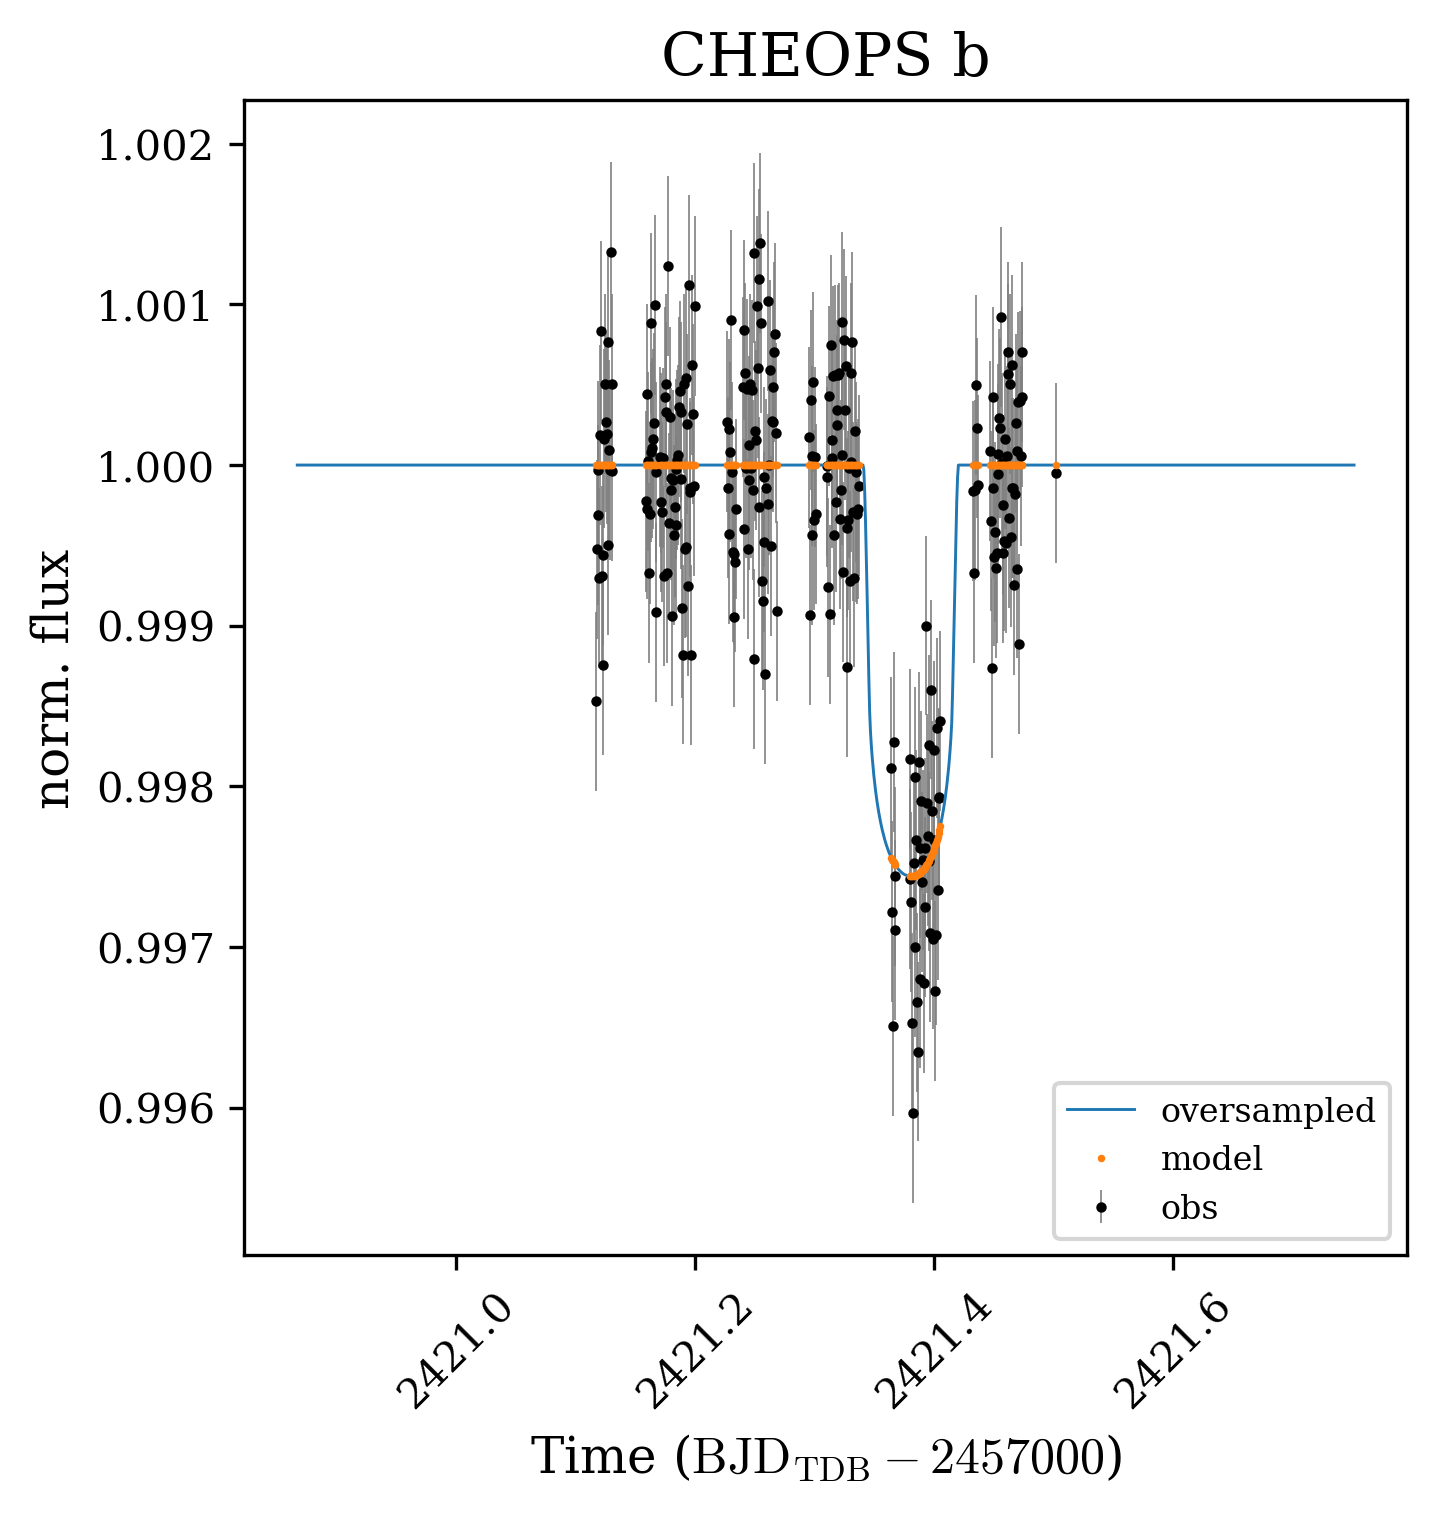

In [28]:
fig = plt.figure()

plt.title("CHEOPS b")
plt.errorbar(
    time_cheops_b, flux_cheops_b,
    yerr=flux_cheops_err_b,
    color='black',
    fmt='o',
    ms=1.5,
    ls='',
    ecolor='gray',
    elinewidth=0.4,
    capsize=0,
    label="obs",
    zorder=6
)

plt.plot(
    time_over,
    flux_model_over,
    color='C0',
    marker='None',
    ls='-',
    lw=0.7,
    label='oversampled',
    zorder=7
)

plt.plot(
    time_cheops_b,
    flux_model,
    color='C1',
    marker='o',
    ms=1.8,
    mec='None',
    ls='',
    label='model',
    zorder=8
)

plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize=8)

# # a zoom
# x1, x2 = 1666, 1667.25
# plt.xlim(x1,x2)

plt.xlabel("Time ($\mathrm{BJD_{TDB}} - 2457000$)")
plt.ylabel("norm. flux")

plt.show()
plt.close(fig)

In [29]:
flux_model = compute_single_flux_pytransit(
    tm, 
    time_cheops_c, 
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["cheops"],
    n_over=1,
    texpd=None
)

# just to have a full model (oversampled) and covering the gaps
texpover = 60*cst.sec2day
time_over = np.arange(time_cheops_c.min()-0.25, time_cheops_c.max()+0.25, texpover)
flux_model_over = compute_single_flux_pytransit(
    tm,
    time_over,
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["cheops"],
    n_over=1,
    texpd=None
)

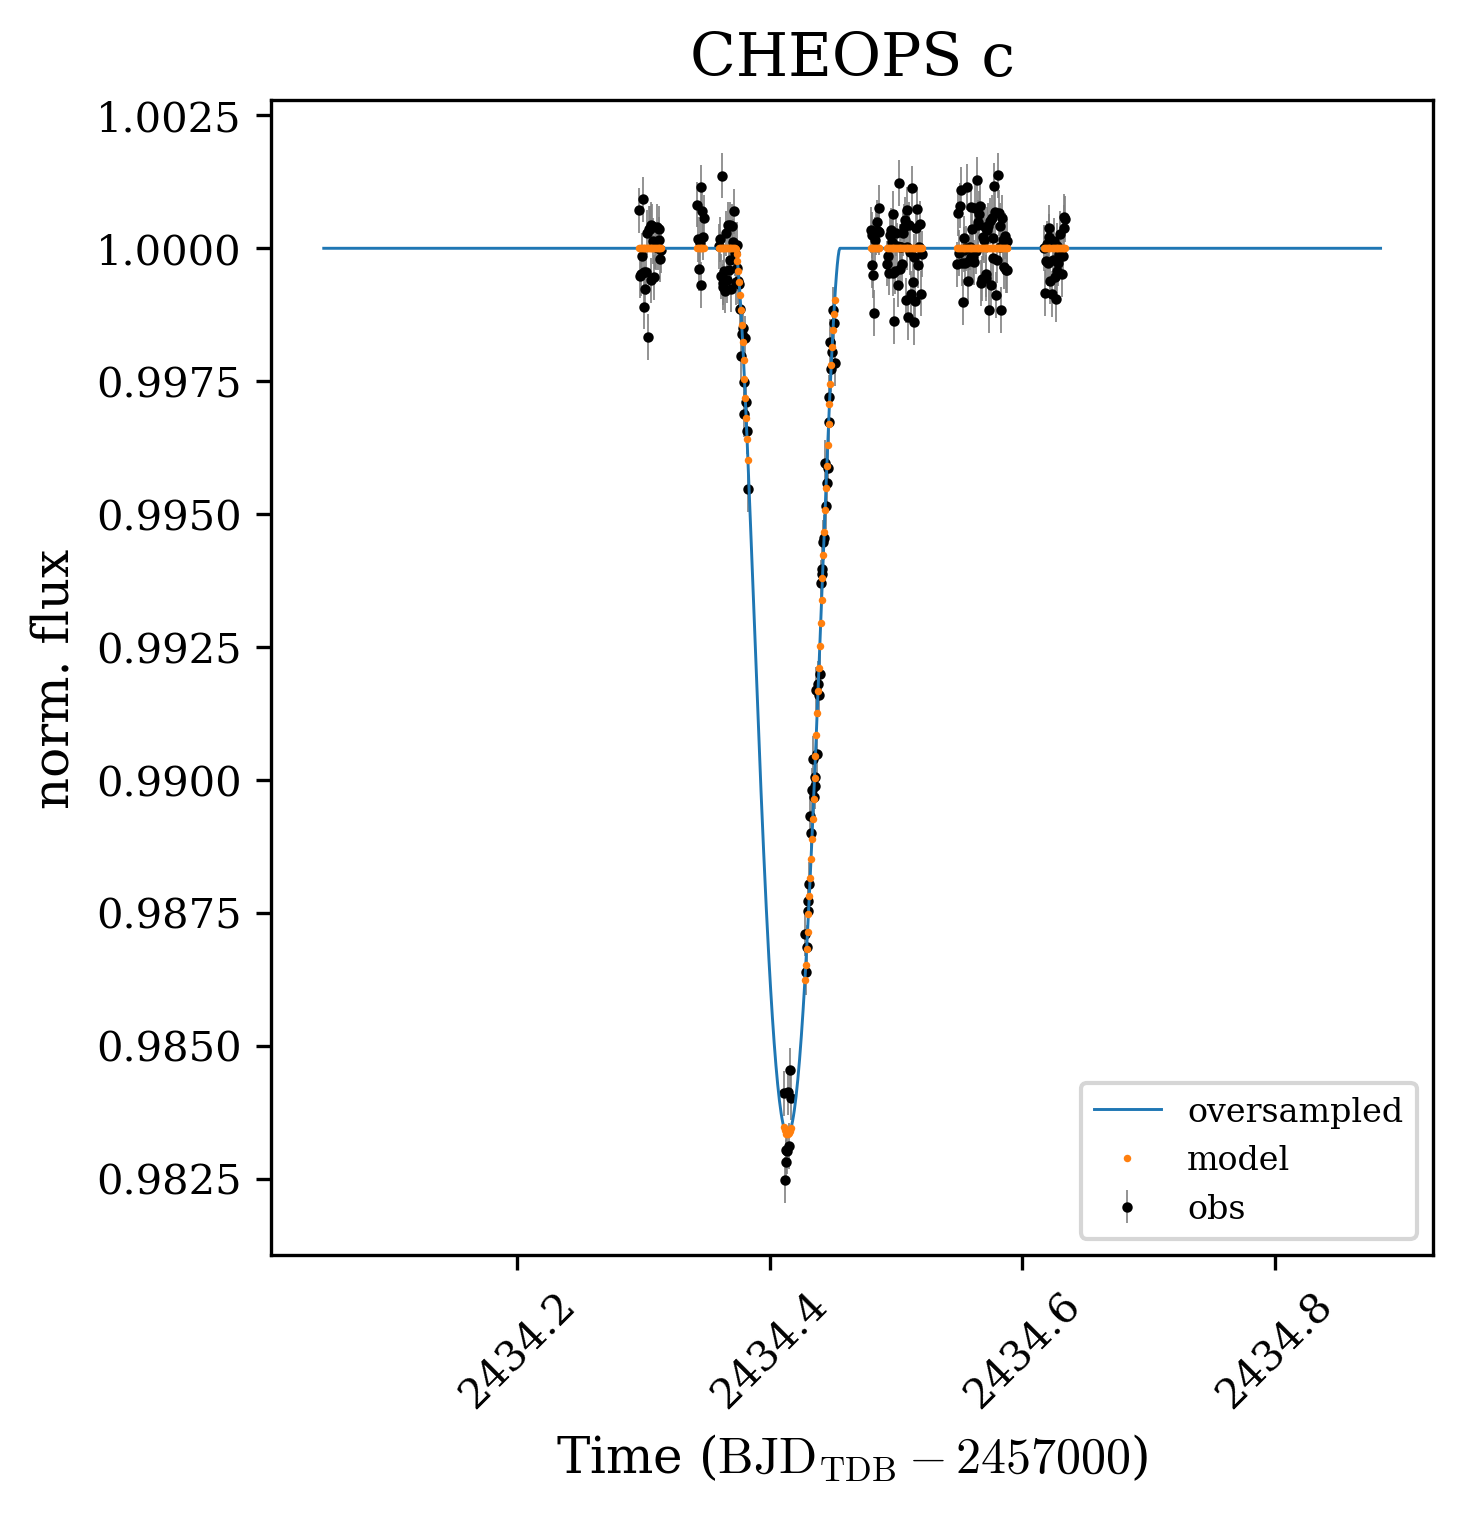

In [30]:
fig = plt.figure()

plt.title("CHEOPS c")
plt.errorbar(
    time_cheops_c, flux_cheops_c,
    yerr=flux_cheops_err_c,
    color='black',
    fmt='o',
    ms=1.5,
    ls='',
    ecolor='gray',
    elinewidth=0.4,
    capsize=0,
    label="obs",
    zorder=6
)

plt.plot(
    time_over,
    flux_model_over,
    color='C0',
    marker='None',
    ls='-',
    lw=0.7,
    label='oversampled',
    zorder=7
)

plt.plot(
    time_cheops_c,
    flux_model,
    color='C1',
    marker='o',
    ms=1.8,
    mec='None',
    ls='',
    label='model',
    zorder=8
)

plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize=8)

# # a zoom
# x1, x2 = 1666, 1667.25
# plt.xlim(x1,x2)

plt.xlabel("Time ($\mathrm{BJD_{TDB}} - 2457000$)")
plt.ylabel("norm. flux")

plt.show()
plt.close(fig)

In [31]:
flux_model = compute_single_flux_pytransit(
    tm, 
    time_cheops_bc, 
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["cheops"],
    n_over=1,
    texpd=None
)

# just to have a full model (oversampled) and covering the gaps
texpover = 60*cst.sec2day
time_over = np.arange(time_cheops_bc.min()-0.25, time_cheops_bc.max()+0.25, texpover)
flux_model_over = compute_single_flux_pytransit(
    tm,
    time_over,
    transits, durations,
    rp_rs, per, aRs, inc, ecc, w,
    ld_quads["cheops"],
    n_over=1,
    texpd=None
)

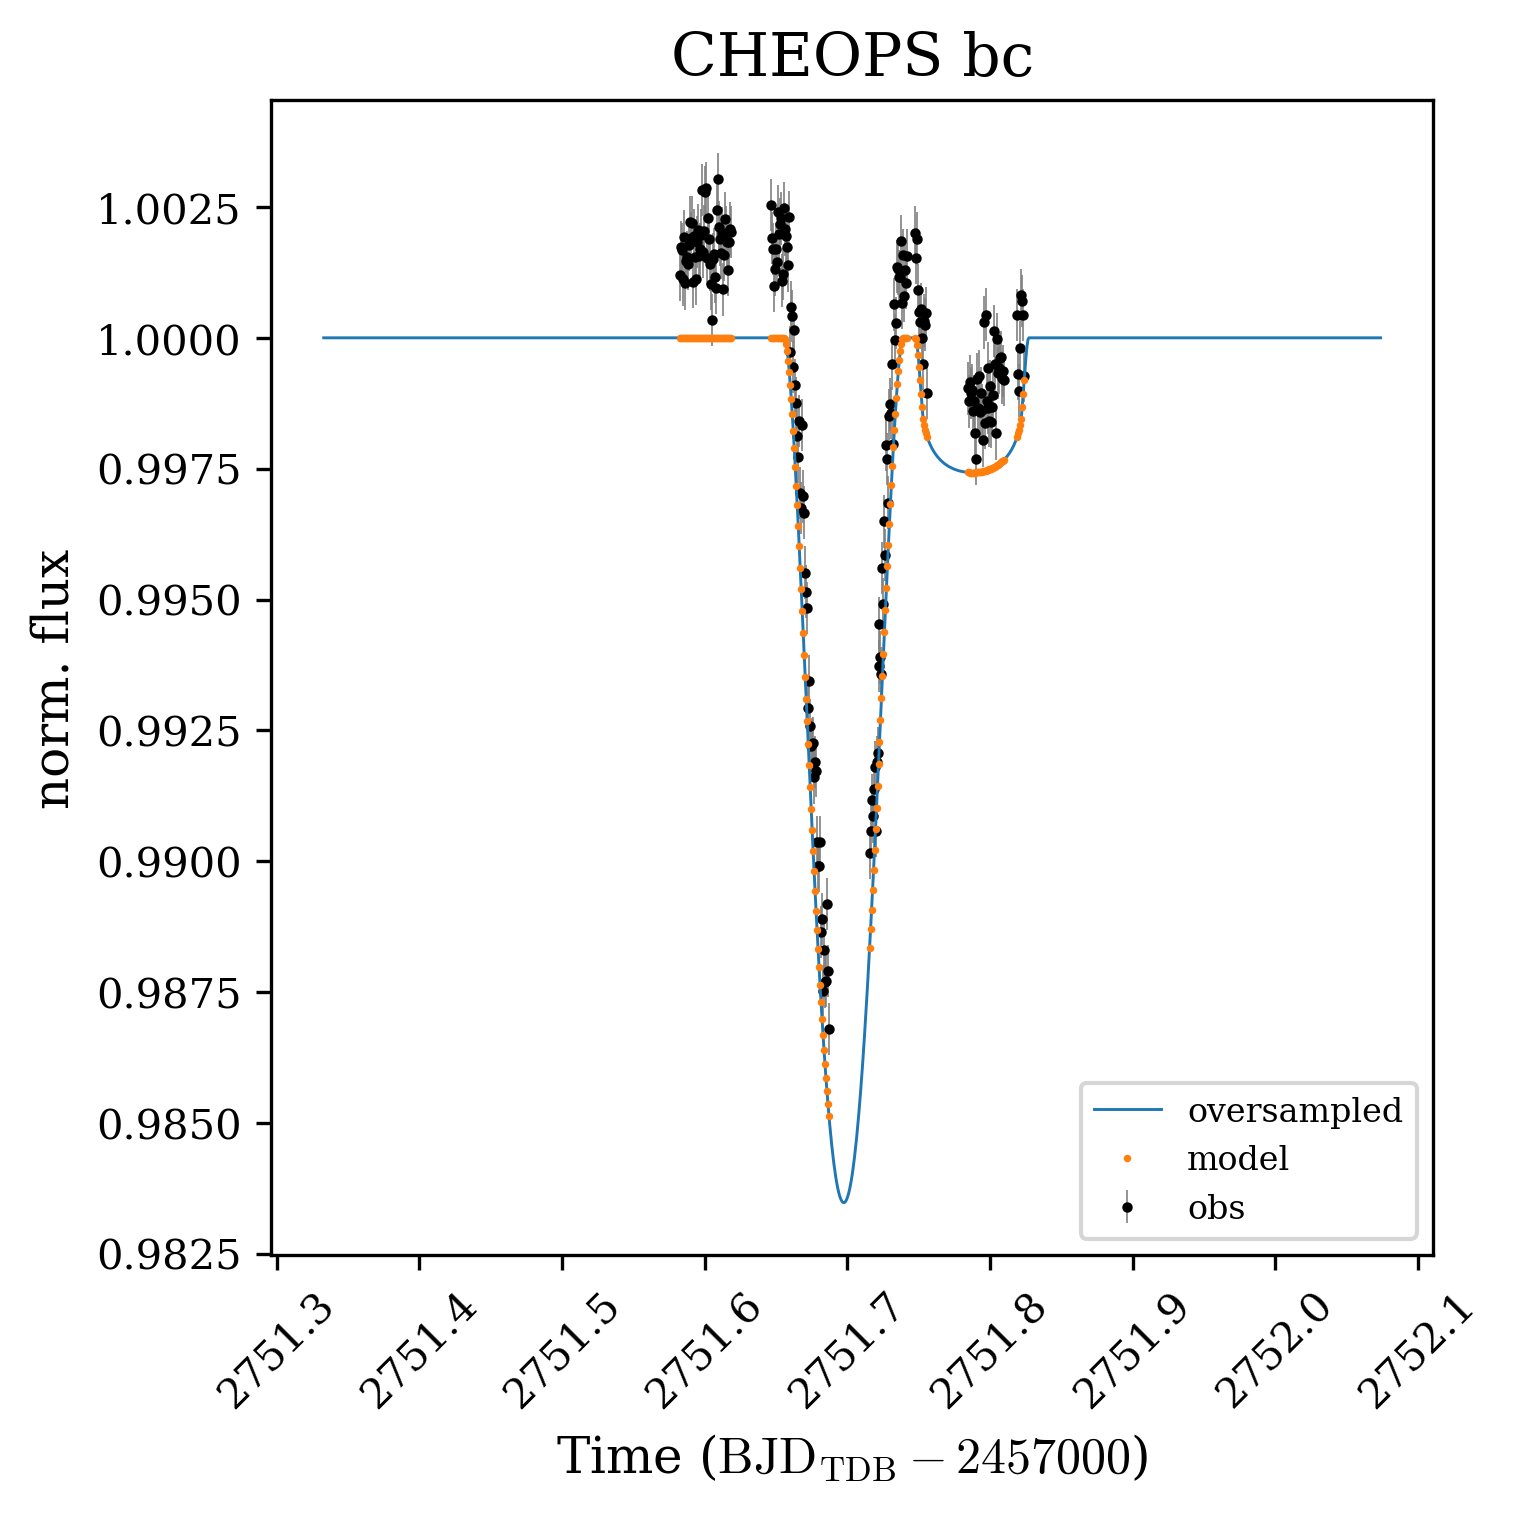

In [32]:
fig = plt.figure()

plt.title("CHEOPS bc")
plt.errorbar(
    time_cheops_bc, flux_cheops_bc,
    yerr=flux_cheops_err_bc,
    color='black',
    fmt='o',
    ms=1.5,
    ls='',
    ecolor='gray',
    elinewidth=0.4,
    capsize=0,
    label="obs",
    zorder=6
)

plt.plot(
    time_over,
    flux_model_over,
    color='C0',
    marker='None',
    ls='-',
    lw=0.7,
    label='oversampled',
    zorder=7
)

plt.plot(
    time_cheops_bc,
    flux_model,
    color='C1',
    marker='o',
    ms=1.8,
    mec='None',
    ls='',
    label='model',
    zorder=8
)

plt.xticks(rotation=45)
plt.legend(loc='lower right', fontsize=8)

# # a zoom
# x1, x2 = 1666, 1667.25
# plt.xlim(x1,x2)

plt.xlabel("Time ($\mathrm{BJD_{TDB}} - 2457000$)")
plt.ylabel("norm. flux")

plt.show()
plt.close(fig)